This notebook explains a simple implementation of Standard Neural Network for the task of handwritten digit classification.

# Import Libraries

In [22]:
import numpy as np                 # FOR MULTI-DIMENTIONAL ARRAY COMPUTATIONS
import matplotlib.pyplot as plt    # FOR  PLOTING
import matplotlib
from scipy.io import loadmat       # FOR LOADING THE DATASET
from sklearn.utils import shuffle  # FOR SHUFFLING THE DATASET

from sklearn.metrics import classification_report, confusion_matrix # FOR TESTING

# Loading data into memory

In [23]:
mnist = loadmat("../input/mnist-original/mnist-original.mat")

data = mnist["data"].T 
label = mnist["label"][0]

# Data Preprocessing

In [24]:
# NORMALIZING THE DATASET
X = data/255.

nDigits = 10 # NUMBER OF DIGITS TO CLASSIFY

#DATA DIMENTIONS
xDims = data.shape
yDims = [label.shape[0],nDigits]

# CONVERTING THE LABELS TO ONE-HOT VECTOR
yOneHot = np.zeros(yDims) # ALL ZEROS MATRIX
for i in range(yDims[0]):
    yOneHot[i,int(label[i])]=1
    
Y = yOneHot

# Viewing the Dataset

The label for the following example is [0]


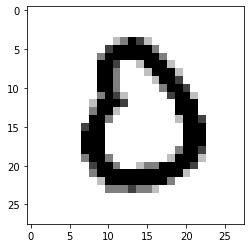

In [25]:
index = 201
plt.imshow(X[index,:].reshape(28,28),cmap=matplotlib.cm.binary)
print("The label for the following example is " + str(np.where(Y[index,:]==1)[0]))

# Randomly Splitting the Data

In [26]:
# DATA SHUFFLING
X, Y = shuffle(X, Y, random_state=0)

#DATA SPLITTING
m = 60000                # NUMBER OF TRAINING EXAMPLES
mTest = X.shape[0] - m   # NUMBER OF TEST EXAMPLES

xTrain = X[:m,:]
yTrain = Y[:m,:].reshape(m, nDigits)
xTest = X[m:,:]
yTest = Y[m:,:].reshape(mTest,nDigits)

# Initializing the Parameters

In [27]:
def initialize_parameters(layer_dims):
    
    L = len(layer_dims) # NUMBER OF LAYERS
    parameters = {}
    
    for l in range(1,L):
        
        #KAIMING WEIGHTS INITIALIZATION
        parameters["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2./layer_dims[l-1])
        parameters["b"+str(l)] = np.zeros((layer_dims[l],1))
        

    return parameters

# Activation functions and their Derivatives

In [28]:
#ACTIVATION FUNCTIONS
def softmax(Z):
    expZ = np.exp(Z - np.max(Z)) # FOR NUMERICAL STABILITY

    A = expZ/np.sum(expZ, axis = 0, keepdims = True)
    cache = Z
    return A, Z

def relu(Z):
    A = np.maximum(Z, 0)
    cache = Z
    return A, cache

#DERIVATIVES
def softmax_backward(AL, Y):
    dZ = AL - Y
    return dZ
    
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy = True)
    
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)
    
    return dZ

# Forward Propagation Functions

In [29]:
def linear_forward(A, W, b):
    
    # INPUTS:
    # A : previous layer activation
    # W : current layer Weights
    # b : current layer bias
    
    Z = np.dot(W,A) + b # calculating the linear function
    cache = (A, W, b)   # a cache is maintained, which is used during back propagation step
    
    return Z,cache

In [30]:
def activation_forward(A_prev, W, b, activation):
    
    # INPUTS:
    # A : previous layer activation
    # W : current layer Weights
    # b : current layer bias
    # activation : type of activation function to use: "relu" or "softmax"
    
    # calling the linear_forward()
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
        
    cache = (linear_cache, activation_cache) # cache for back propagation step
    
    return A, cache
        

In [31]:
def L_model_forward(X, parameters):
    
    # INPUTS:
    # X : input data
    # parameters : Weights and bias
    
    L = len(parameters) // 2 # NUMBER OF LAYERS
    A = X
    caches = []
    
    # l-1 layers of forward pass
    for l in range(1,L):
        A_prev = A
        A, cache = activation_forward(A_prev, parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        caches.append(cache)
    
    # last layer forward pass
    AL, cache = activation_forward(A, parameters["W"+str(L)],parameters["b"+str(L)],"softmax")
    caches.append(cache)
    
    return AL, caches

# Cost Function

In [32]:
def compute_cost(Y_hat, Y):
    
    # INPUTS:
    # Y_hat : predicted labels
    # Y : original labels
    
    cost = - (np.mean(np.sum(Y*np.log(Y_hat+1e-8), axis = 0, keepdims = True)))
    return cost

# Backward Propagation functions

In [33]:
def linear_backward(dZ, cache):
    
    # INPUTS:
    # dZ : derivative w.r.t this layer linear function
    # cache : cache from linear_forward() of this layer
    
    A_prev, W, b = cache
    m = A_prev.shape[1] # Number of Training Examples
    
    # Derivatives
    dW = (1./m)*np.dot(dZ,A_prev.T)
    db = (1./m)*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)

    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    assert (dA_prev.shape == A_prev.shape)

    return (dA_prev, dW, db)

In [34]:
def activation_backward(dA, cache, activation):
    
    # INPUT:
    # dA : derivative w.r.t the activation of this layer
    # cache : cache from activation_forward() of this layer
    # activation : type of activation function
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = dA
        
    # calling the linear_backward()
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [35]:
def L_model_backward(AL, Y, cache):
    
    # INPUT:
    # AL : last layer activations
    # Y : original labels
    # cache :  caches list
    
    grads = {}        # GRADIENTS DICTIONARY
    L = len(cache)    # NUMBER OF LAYERS
    m = AL.shape[1]   # NUMBER OF TRAINING EXAMPLES
    
    Y = Y.reshape(AL.shape)
    
    # derivation w.r.t the last layer linear function
    dZL = softmax_backward(AL, Y)
    current_cache = cache[L-1]
    dA_prev_temp, dW_temp, db_temp = activation_backward(dZL, current_cache, "softmax")
    
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    grads["dA" + str(L-1)] = dA_prev_temp

    for l in reversed(range(L-1)):
        
        current_cache = cache[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
    
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        grads["dA" + str(l)] = dA_prev_temp
        
    return grads

In [36]:
def update_parameters(parameters, grads, learning_rate):
    
    # INPUT:
    # parameters : Weights and bias
    # grads : Gradient dictionary
    # learning_rate
    
    L = len(parameters) // 2 # NUMBER OF LAYERS
    
    # UPDATING PARAMETERS
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]

    return parameters

# Layers Dimensions

using 2 hidden layer network

Note: The decrease in the number of units in the hidden layers should be gradual.

In [37]:
layers_dims = [784, 120, 32, 10]

# Model Definition

In [38]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 300):
    
    # INPUTS:
    # X : input data
    # Y : output labels
    # layers_dims : layers dimensions
    # learning_rate
    # num_iterations : number of iterations over the training examples
    
    costs = []
    
    # INITIALIZING PARAMETERS
    parameters = initialize_parameters(layers_dims)
    
    
    for i in range(0, num_iterations):
        
        # FORWARD PASS
        AL, caches = L_model_forward(X, parameters)
        
        # COST COMPUTATION
        cost = compute_cost(AL, Y)
        
        # BACKWARD PASS
        grads = L_model_backward(AL, Y, caches)
        
        # LEARNING RATE DECAY
        learning = (0.9/(np.sqrt(i)+1e-8))*learning_rate
        
        # PARAMETER UPDATES
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # PRINTING THE COST
        if i % 10 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
    
    # TRAINING ACCURACY
    predictions = np.argmax(AL, axis=0)
    labels = np.argmax(Y, axis=0)    
    print("Trainig Accuracy: "  + str(np.sum((predictions == labels)/m)))

    # PLOTING THE COST w.r.t NUMBER OF ITERATIONS
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.349535
Cost after iteration 10: 1.152568
Cost after iteration 20: 0.806096
Cost after iteration 30: 0.704070
Cost after iteration 40: 0.508100
Cost after iteration 50: 0.525815
Cost after iteration 60: 0.391576
Cost after iteration 70: 0.367623
Cost after iteration 80: 0.361819
Cost after iteration 90: 0.337579
Cost after iteration 100: 0.314972
Cost after iteration 110: 0.302013
Cost after iteration 120: 0.291841
Cost after iteration 130: 0.283115
Cost after iteration 140: 0.275424
Cost after iteration 150: 0.268656
Cost after iteration 160: 0.262647
Cost after iteration 170: 0.256943
Cost after iteration 180: 0.250966
Cost after iteration 190: 0.244802
Trainig Accuracy: 0.9311166666666668


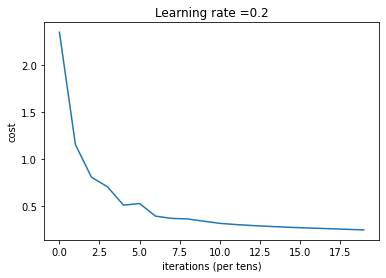

In [39]:
parameters = L_layer_model(xTrain.T, yTrain.T, layers_dims, learning_rate = 0.2, num_iterations = 200)

In [47]:
parametersre = L_layer_model(xTrain.T, yTrain.T, layers_dims, learning_rate = 0.1, num_iterations = 200)

Cost after iteration 0: 2.284071
Cost after iteration 10: 1.733120
Cost after iteration 20: 1.206784
Cost after iteration 30: 0.870337
Cost after iteration 40: 0.689934
Cost after iteration 50: 0.587620
Cost after iteration 60: 0.523154
Cost after iteration 70: 0.480007
Cost after iteration 80: 0.457155
Cost after iteration 90: 0.433604
Cost after iteration 100: 0.403115
Cost after iteration 110: 0.384639
Cost after iteration 120: 0.370514


KeyboardInterrupt: 

# Testing

In [40]:
def predict(X, Y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # NUMBER OF LAYERS
    
    predictions = np.zeros((10,m))
    
    # FORWARD PROPAGATION
    probas, _ = L_model_forward(X, parameters)

    
    # COLLAPSING THE ONE-HOT VECTORS
    predictions = np.argmax(probas, axis=0)
    labels = np.argmax(Y, axis=0)

    # ACCURACY OF THE MODEL
    
    print("Test Accuracy: "  + str(np.sum((predictions == labels)/m)))
    
    return predictions

In [41]:
predictions = predict(xTest.T, yTest.T, parameters)

Test Accuracy: 0.9285000000000003


# Viewing Predictions

Predictions vs Actual labels:
The prediction for the following example is 0
The label for the following example is [0]


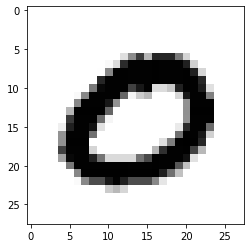

In [43]:
index = 200
plt.imshow(xTest[index,:].reshape(28,28),cmap=matplotlib.cm.binary)

print("Predictions vs Actual labels:")
print("The prediction for the following example is " + str(predictions[index]))
print("The label for the following example is " + str(np.where(yTest[index,:]==1)[0]))

# Classification Report

In [42]:
print(confusion_matrix(predictions, np.argmax(yTest.T, axis=0)))
print(classification_report(predictions, np.argmax(yTest.T, axis=0)))

[[ 939    1    9    4    0    8   10    5    9    7]
 [   0 1117    9    5    2    4    2   10   14    4]
 [   3    7  921    8    4   10    9   14   12    2]
 [   2    2   12  929    0   12    2    5   25   13]
 [   1    0   18    1  935    5    9    7    6   51]
 [   3    5    7   33    0  823   20    4   33    9]
 [   8    2    9    1   13   14  890    0    5    1]
 [   2    3   25    8    0    1    0 1019    2   23]
 [   9   10   16   12    3   10    3    2  841    7]
 [   1    1    3    9   26    3    0   13   13  871]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       992
           1       0.97      0.96      0.97      1167
           2       0.90      0.93      0.91       990
           3       0.92      0.93      0.92      1002
           4       0.95      0.91      0.93      1033
           5       0.92      0.88      0.90       937
           6       0.94      0.94      0.94       943
           7       0.94      0.94   

# Mislabeled Images

In [57]:
def print_mislabeled_images(X, Y, p):
    
    # INPUTS:
    # X -- dataset
    # Y -- true labels
    # p -- predictions
    
    mislabeled_indices = []
    labels = np.argmax(Y, axis=0)

    for i in range(p.shape[0]):
        if p[i] != labels[i]:
            mislabeled_indices.append(i)

    num_images = len(mislabeled_indices)
    print("Number of mislabeled Images: "+str(num_images))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots

    for i in range(10):
        index = mislabeled_indices[i]
        plt.subplot(2, 10, i + 1)
        plt.imshow(X[:,index].reshape(28,28))
        plt.axis('off')
        plt.title("Prediction: " + str(p[index]))


Number of mislabeled Images: 715


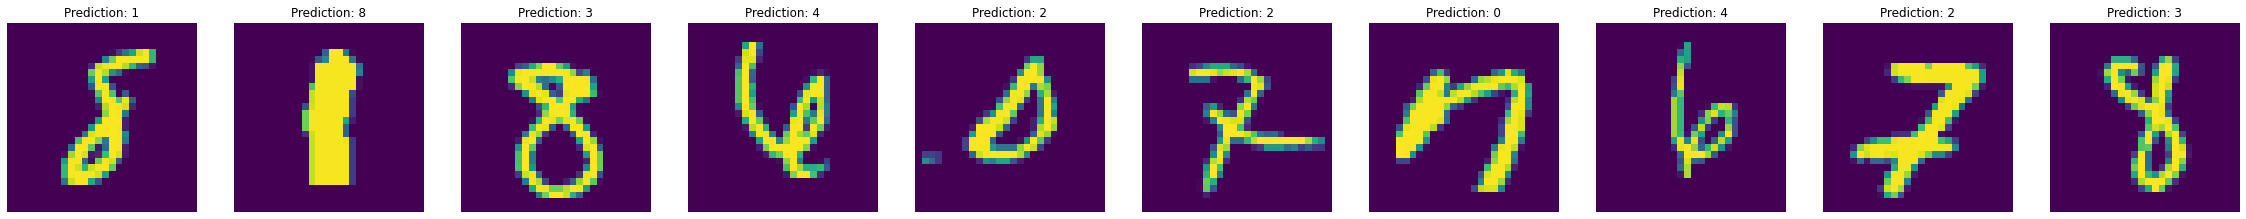

In [58]:
print_mislabeled_images(xTest.T, yTest.T, predictions)